In [55]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx

## Part 1: London’s underground resilience


  station_origin station_destination  flows  population   jobs     distance
0     Abbey Road   Bank and Monument      0         599  78549  8131.525097
1     Abbey Road             Beckton      1         599    442  8510.121774
2     Abbey Road           Blackwall      3         599    665  3775.448872
3     Abbey Road        Canary Wharf      1         599  58772  5086.514220
4     Abbey Road        Canning Town     37         599  15428  2228.923167
(61474, 6)
Index(['station_origin', 'station_destination', 'flows', 'population', 'jobs',
       'distance'],
      dtype='object')
station_origin          object
station_destination     object
flows                    int64
population               int64
jobs                     int64
distance               float64
dtype: object


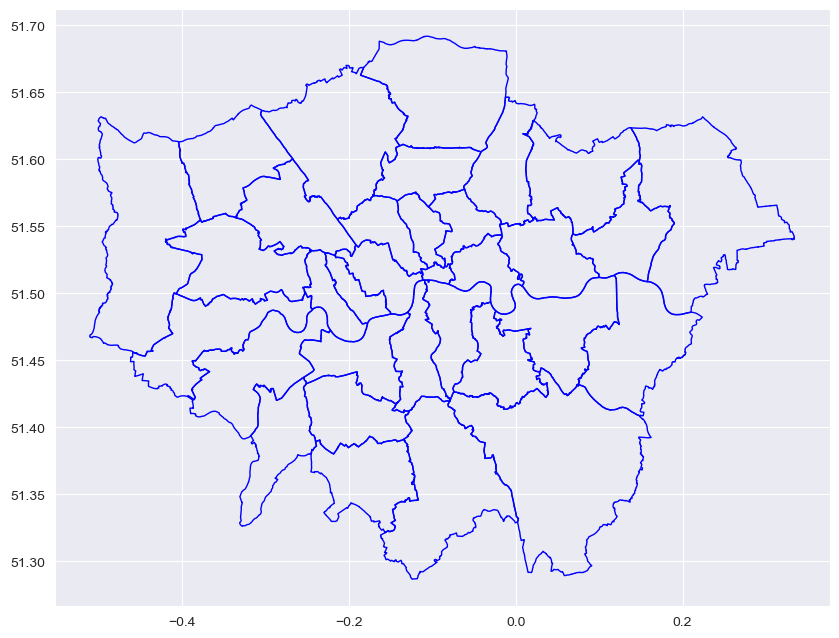

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 33 entries, 293 to 325
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   OBJECTID      33 non-null     int64   
 1   lad15cd       33 non-null     object  
 2   lad15nm       33 non-null     object  
 3   lad15nmw      33 non-null     object  
 4   GlobalID      33 non-null     object  
 5   SHAPE_Length  33 non-null     float64 
 6   SHAPE_Area    33 non-null     float64 
 7   geometry      33 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(4)
memory usage: 2.3+ KB


In [56]:
# Read in the data
df = pd.read_csv('/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/Assessment/london_flows.csv')

print(df.head())
print(df.shape)
print(df.columns)
print(df.dtypes)

uk = gpd.read_file('/Users/zonghe/Documents/Modules/Term2/CASA0002 Urban Simulation/week 2/practice/Data/LAD_Dec_2015_Generalised_Clipped_Boundaries_GB.geojson')
London = uk[uk.lad15cd.str.contains("E09")]
London.plot(figsize = (10,15), facecolor = "None", edgecolor = "b")
plt.show()
London.crs
London.info()


In [57]:
#order it by borough code - *This step will be important later on*
London.sort_values(by=["lad15cd"], inplace = True)

#extract the centroids
London["Centroids"] = London.geometry.centroid

London.set_index('lad15cd', inplace=True, drop=True)
#calculate distances from all borough centroids to all borough centroids
distances = London.rename_axis('Orig').Centroids.apply(lambda x: London.rename_axis('Dest').Centroids.distance(x)).stack().reset_index()
distances.rename(columns = {0:'Dist'}, inplace=True)
distances.sort_values(by=["Orig", "Dest"], inplace = True)
London.reset_index(inplace=True)
distances.head(10)

/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_19759/526331813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  London.sort_values(by=["lad15cd"], inplace = True)
/var/folders/1k/27mkp8bj3ps60c3nmr7rbqzh0000gn/T/ipykernel_19759/526331813.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  London["Centroids"] = London.geometry.centroid
/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Orig,Dest,Dist
0,E09000001,E09000001,0.000000
1,E09000001,E09000002,0.227536
2,E09000001,E09000003,0.155405
3,E09000001,E09000004,0.240824
4,E09000001,E09000005,0.180855
5,E09000001,E09000006,0.202504
6,E09000001,E09000007,0.072429
7,E09000001,E09000008,0.159169
8,E09000001,E09000009,0.238728
9,E09000001,E09000010,0.136680


In [62]:
# 创建图
G = nx.from_pandas_edgelist(df, 'station_origin', 'station_destination', ['flows','distance'])

# 计算节点度中心性、介数中心性和紧密中心性
deg_cen = nx.degree_centrality(G)
bet_cen = nx.betweenness_centrality(G)
eig_cen = nx.eigenvector_centrality(G)

# 将结果转化为DataFrame并排序
deg_cen_df = pd.DataFrame(list(deg_cen.items()), columns=['station', 'degree_centrality'])
deg_cen_df = deg_cen_df.sort_values('degree_centrality', ascending=False).reset_index(drop=True)

bet_cen_df = pd.DataFrame(list(bet_cen.items()), columns=['station', 'betweenness_centrality'])
bet_cen_df = bet_cen_df.sort_values('betweenness_centrality', ascending=False).reset_index(drop=True)

eig_cen_df = pd.DataFrame(list(eig_cen.items()), columns=['station', 'closeness_centrality'])
eig_cen_df = eig_cen_df.sort_values('closeness_centrality', ascending=False).reset_index(drop=True)

# 输出前10个节点
print("Top 10 ranked nodes for Degree Centrality:\n", deg_cen_df.head(10))
print("\nTop 10 ranked nodes for Betweenness Centrality:\n", bet_cen_df.head(10))
print("\nTop 10 ranked nodes for Eigenvector Centrality:\n", eig_cen_df.head(10))

Top 10 ranked nodes for Degree Centrality:
                 station  degree_centrality
0             Stratford           0.922111
1  Highbury & Islington           0.806533
2           Whitechapel           0.781407
3         West Brompton           0.776382
4          Canada Water           0.771357
5          Canary Wharf           0.771357
6      Liverpool Street           0.768844
7     Bank and Monument           0.766332
8              Richmond           0.766332
9          Canning Town           0.763819

Top 10 ranked nodes for Betweenness Centrality:
                 station  betweenness_centrality
0             Stratford                0.098553
1      Liverpool Street                0.034307
2          Canary Wharf                0.027956
3     Bank and Monument                0.027956
4          Canning Town                0.027757
5              West Ham                0.024551
6  Highbury & Islington                0.023023
7           Whitechapel                0.019682
8

此代码首先读取名为 london_underground.csv 的数据集，然后使用 networkx 库将其转换为图。接下来，它计算了节点的度中心性、介数中心性和紧密中心性，并将结果转换为DataFrame，并按各自的中心性度量进行排序，最后输出前10个节点。
在这个部分中，使用了以下三种 centrality measures 方法来衡量节点的重要性：
1. Degree Centrality：表示一个节点有多少个直接连接的邻居节点。公式为：$C_D(v) = \frac{d_v}{n-1}$，其中 $d_v$ 是节点 $v$ 的度，即与节点 $v$ 直接相连的边的数量，$n$ 是网络中的节点数。在地铁网络中，该指标可以反映一个车站的通行量，因为车站直接连接的边数越多，代表越多的人会通过该车站。
2. Betweenness Centrality：表示节点在网络中的所有最短路径中被经过的次数。公式为：$C_B(v) = \sum_{s \neq v \neq t} \frac{\sigma_{st}(v)}{\sigma_{st}}$，其中 $\sigma_{st}$ 是节点 $s$ 和节点 $t$ 之间的最短路径数量，$\sigma_{st}(v)$ 是最短路径数量中经过节点 $v$ 的路径数量。在地铁网络中，该指标可以反映一个车站在不同区域之间的联系程度，如果一个车站位于多条最短路径上，那么该车站就更为重要。
3.Eigenvector Centrality：表示一个节点对整个网络的控制力度。公式为：$Ax = \lambda x$，其中 $A$ 是邻接矩阵，$x$ 是节点的中心性，$\lambda$ 是对应的特征值。在地铁网络中，该指标可以反映一个车站与其他重要车站的联系程度，如果一个车站直接连接到其他很多重要车站，那么该车站的 Eigenvector Centrality 就更高。

In [59]:
# I.2. Impact measures
import copy

# Create a function to compute the number of connected components in the network after node removal
def count_connected_components(G):
    G_copy = copy.deepcopy(G)
    return len(list(nx.connected_components(G_copy)))

# Create a function to compute the size of the largest connected component in the network after node removal
def size_largest_component(G):
    G_copy = copy.deepcopy(G)
    components = list(nx.connected_components(G_copy))
    largest_component = max(components, key=len)
    return len(largest_component)


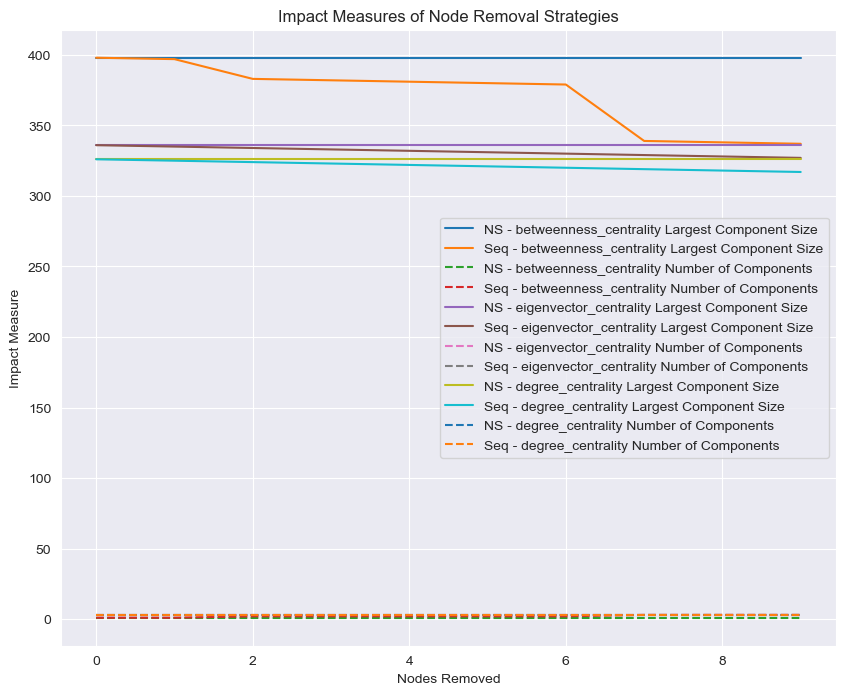

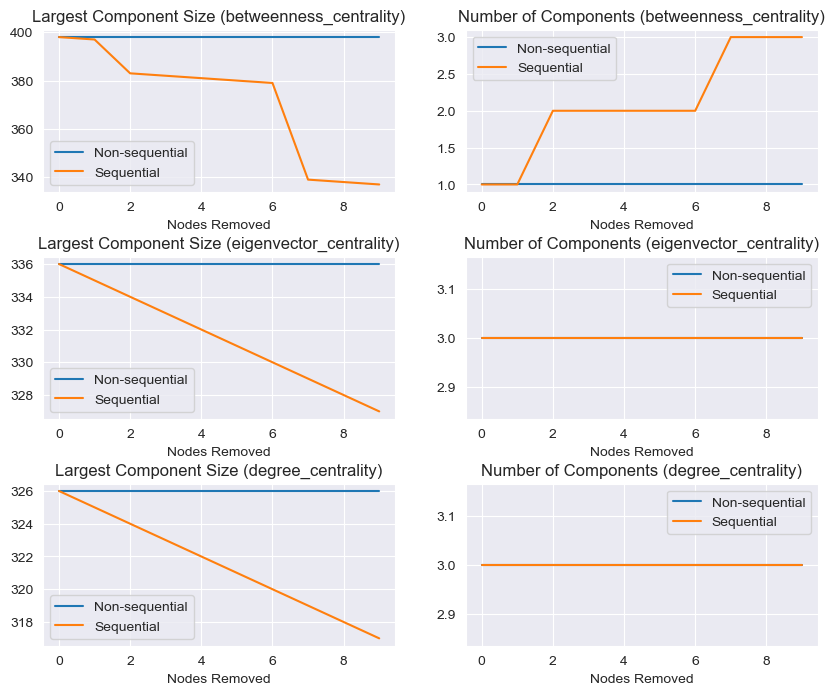

In [63]:
# Create a function to perform non-sequential node removal based on a given centrality measure
def nonseq_removal(G, centrality_measure):
    # Compute centrality measure for all nodes in the network
    node_centrality = centrality_measure(G)

    # Sort nodes by their centrality score
    nodes_sorted = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)

    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []

    # Remove nodes in order of decreasing centrality score and compute impact measures
    for i in range(min(10, len(nodes_sorted))):
        node = nodes_sorted[i][0]
        G_copy = copy.deepcopy(G)
        G_copy.remove_node(node)
        num_components.append(count_connected_components(G_copy))
        largest_component_size.append(size_largest_component(G_copy))

    return num_components, largest_component_size


# Create a function to perform sequential node removal based on a given centrality measure
def seq_removal(G, centrality_measure):
    # Initialize lists to store the impact measures for each node removal
    num_components = []
    largest_component_size = []

    # Continue removing nodes until 10 nodes have been removed
    for i in range(min(10, len(G.nodes))):
        # Compute centrality measure for all nodes in the network
        node_centrality = centrality_measure(G)

        # Sort nodes by their centrality score
        nodes_sorted = sorted(node_centrality.items(), key=lambda x: x[1], reverse=True)

        # Remove the highest ranked node and compute impact measures
        node = nodes_sorted[0][0]
        G.remove_node(node)
        num_components.append(count_connected_components(G))
        largest_component_size.append(size_largest_component(G))

    return num_components, largest_component_size


# Define the centrality measures to use
centrality_measures = [nx.betweenness_centrality, nx.eigenvector_centrality, nx.degree_centrality]

# Initialize lists to store results for each centrality measure
ns_num_components = []
ns_largest_component_size = []
seq_num_components = []
seq_largest_component_size = []

# Perform node removal for each centrality measure using both non-sequential and sequential strategies
for centrality_measure in centrality_measures:
    # Perform non-sequential removal
    ns_components, ns_size = nonseq_removal(G, centrality_measure)
    ns_num_components.append(ns_components)
    ns_largest_component_size.append(ns_size)

    # Perform sequential removal
    seq_components, seq_size = seq_removal(G, centrality_measure)
    seq_num_components.append(seq_components)
    seq_largest_component_size.append(seq_size)

# Plot the impact measures for each strategy and centrality measure
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.plot(ns_largest_component_size[i], label=f'NS - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(seq_largest_component_size[i], label=f'Seq - {centrality_measures[i].__name__} Largest Component Size')
    plt.plot(ns_num_components[i], linestyle='--', label=f'NS - {centrality_measures[i].__name__} Number of Components')
    plt.plot(seq_num_components[i], linestyle='--', label=f'Seq - {centrality_measures[i].__name__} Number of Components')
plt.title('Impact Measures of Node Removal Strategies')
plt.xlabel('Nodes Removed')
plt.ylabel('Impact Measure')
plt.legend()

plt.show()

# Plot the impact measures for each strategy and centrality measure for better understanding and analysis
plt.figure(figsize=(10, 8))
for i in range(len(centrality_measures)):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(ns_largest_component_size[i], label='Non-sequential')
    plt.plot(seq_largest_component_size[i], label='Sequential')
    plt.title(f'Largest Component Size ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Size of Largest Component')
    plt.legend()

    plt.subplot(3, 2, 2*i+2)
    plt.plot(ns_num_components[i], label='Non-sequential')
    plt.plot(seq_num_components[i], label='Sequential')
    plt.title(f'Number of Components ({centrality_measures[i].__name__})')
    plt.xlabel('Nodes Removed')
    # plt.ylabel('Number of Component')
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()


